In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates with different layouts

In [44]:
files = [
            # ["growth_data/cyrus_blue_020824.txt",
            #   {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "Zn", "H": "B12"},
            #   [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
            #   [["A", "B", "C", "D"], ["E", "F", "G", "H"]],
            #   {"YkgM1": [0, 0], "MG1655": [1, 0]},
            #  12],

            # # good?
            #  ["growth_data/cyrus_pink_020924.txt",
            #  {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
            #  [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
            #  [["A", "B", "C", "D", "E", "F", "G"]],
            #  {"MG1655": [0, 0]},
            #   12],

             # p bad
             # ["growth_data/cyrus_blue_021324.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],


             # also p bad
             # ["growth_data/cyrus_blue_021424.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],

             # ["growth_data/cyrus_blue_021524.txt",
             # {"A": "met", "B": "met", "C": "none", "D": "B12", "E": "Zn","F": "met+B12", "G": "met+Zn", "H": "met+B12+Zn"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],
    
             ["growth_data/cyrus_031524_paraquat_Mn.txt",
             {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
              "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             [["A", "B", "C", "D", "E", "F", "G", "H"]],
             {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
              12],

             # ["growth_data/cyrus_031524_paraquat_Mn_part2.txt",
             # {"A": "Mn 0", "B": "Mn 1", "C": "Mn 2", "D": "Mn 3", "E": "Mn 4","F": "Mn 5", "G": "Mn 6", "H": "Mn 7"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             ["growth_data/cyrus_032024_paraquat_Mn.txt",
             {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
              "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             [["A", "B", "C", "D", "E", "F", "G", "H"]],
             {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
              12],
    
        ]




for i, file in enumerate(files):

    fname = file[0]
    additive = file[1]
    genotype_col = file[2]
    genotype_row = file[3]
    genotype_combinations = file[4]
    n_replicate = file[5]

    al = pl.DataFrame(additive).transpose(include_header=True)
    al = al.rename({"column": "Row", "column_0": "Additive"})
    al = al.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    gl = []
    
    for genotype, idx in genotype_combinations.items():
    
        gl.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

    gl = pl.DataFrame(gl).transpose()
    gl = gl.rename({"column_0": "Genotype", "column_1": "Well"})
    gl = gl.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    if i == 0:    
        df = pl.read_csv(fname, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.with_columns(N_replicate = n_replicate)
        df = df.drop('T600')

        gdf = gl
        adf = al

    else:
        df_add = pl.read_csv(fname, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.with_columns(N_replicate = n_replicate)
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

        gdf = pl.concat([gdf, gl])
        adf = pl.concat([adf, al])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# get minimum OD measured, used to be 1.5
init_df = df.filter(pl.col("Time") > 1.5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df_median = df.filter(pl.col("Time") < 5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD_median")
init_df_median = init_df_median.group_by(["Plate", "Well"]).median()

init_df

# blank_df.head(3)
df.head(3)

shape: (3, 99)
┌──────────┬───────┬───────┬───────┬───┬───────┬───────┬─────────┬─────────────┐
│ Time     ┆ A1    ┆ A2    ┆ A3    ┆ … ┆ H11   ┆ H12   ┆ Plate   ┆ N_replicate │
│ ---      ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---     ┆ ---         │
│ f64      ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64   ┆ str     ┆ i32         │
╞══════════╪═══════╪═══════╪═══════╪═══╪═══════╪═══════╪═════════╪═════════════╡
│ 0.011111 ┆ 0.219 ┆ 0.202 ┆ 0.213 ┆ … ┆ 0.333 ┆ 0.36  ┆ Plate 1 ┆ 12          │
│ 0.036111 ┆ 0.217 ┆ 0.202 ┆ 0.212 ┆ … ┆ 0.402 ┆ 0.356 ┆ Plate 1 ┆ 12          │
│ 0.061111 ┆ 0.216 ┆ 0.202 ┆ 0.212 ┆ … ┆ 0.386 ┆ 0.419 ┆ Plate 1 ┆ 12          │
└──────────┴───────┴───────┴───────┴───┴───────┴───────┴─────────┴─────────────┘

In [45]:
# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate", "N_replicate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on=["Plate", "Row"])
mdf = mdf.join(gdf, on=["Plate", "Well"])
mdf = mdf.join(init_df, on=["Well", "Plate"])
mdf = mdf.join(init_df_median, on=["Well", "Plate"])

mdf = mdf.with_columns(   ((pl.col("Column").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))

# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+11) % 12 + 1).alias("Replicate"))
# mdf.group_by(["Plate","Additive","Genotype"]).size()
# mdf = mdf.filter(pl.col("Genotype") == "MG1655")

In [46]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
])

mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD_median")).alias("Initial_median_corrected_OD"), 
])


mdf.head(5)

shape: (5, 14)
┌──────────┬─────────┬─────────────┬──────┬───┬─────────────┬───────────┬─────────────┬────────────┐
│ Time     ┆ Plate   ┆ N_replicate ┆ Well ┆ … ┆ Initial_OD_ ┆ Replicate ┆ Initial_cor ┆ Initial_me │
│ ---      ┆ ---     ┆ ---         ┆ ---  ┆   ┆ median      ┆ ---       ┆ rected_OD   ┆ dian_corre │
│ f64      ┆ str     ┆ i32         ┆ str  ┆   ┆ ---         ┆ i32       ┆ ---         ┆ cted_OD    │
│          ┆         ┆             ┆      ┆   ┆ f64         ┆           ┆ f64         ┆ ---        │
│          ┆         ┆             ┆      ┆   ┆             ┆           ┆             ┆ f64        │
╞══════════╪═════════╪═════════════╪══════╪═══╪═════════════╪═══════════╪═════════════╪════════════╡
│ 0.011111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.207       ┆ 1         ┆ 0.018       ┆ 0.012      │
│ 0.036111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.207       ┆ 1         ┆ 0.016       ┆ 0.01       │
│ 0.061111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.207       ┆ 1         ┆ 0.015       ┆ 0.009      │
│ 0.086111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.207       ┆ 1         ┆ 0.015       ┆ 0.009      │
│ 0.111111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.207       ┆ 1         ┆ 0.015       ┆ 0.009      │
└──────────┴─────────┴─────────────┴──────┴───┴─────────────┴───────────┴─────────────┴────────────┘

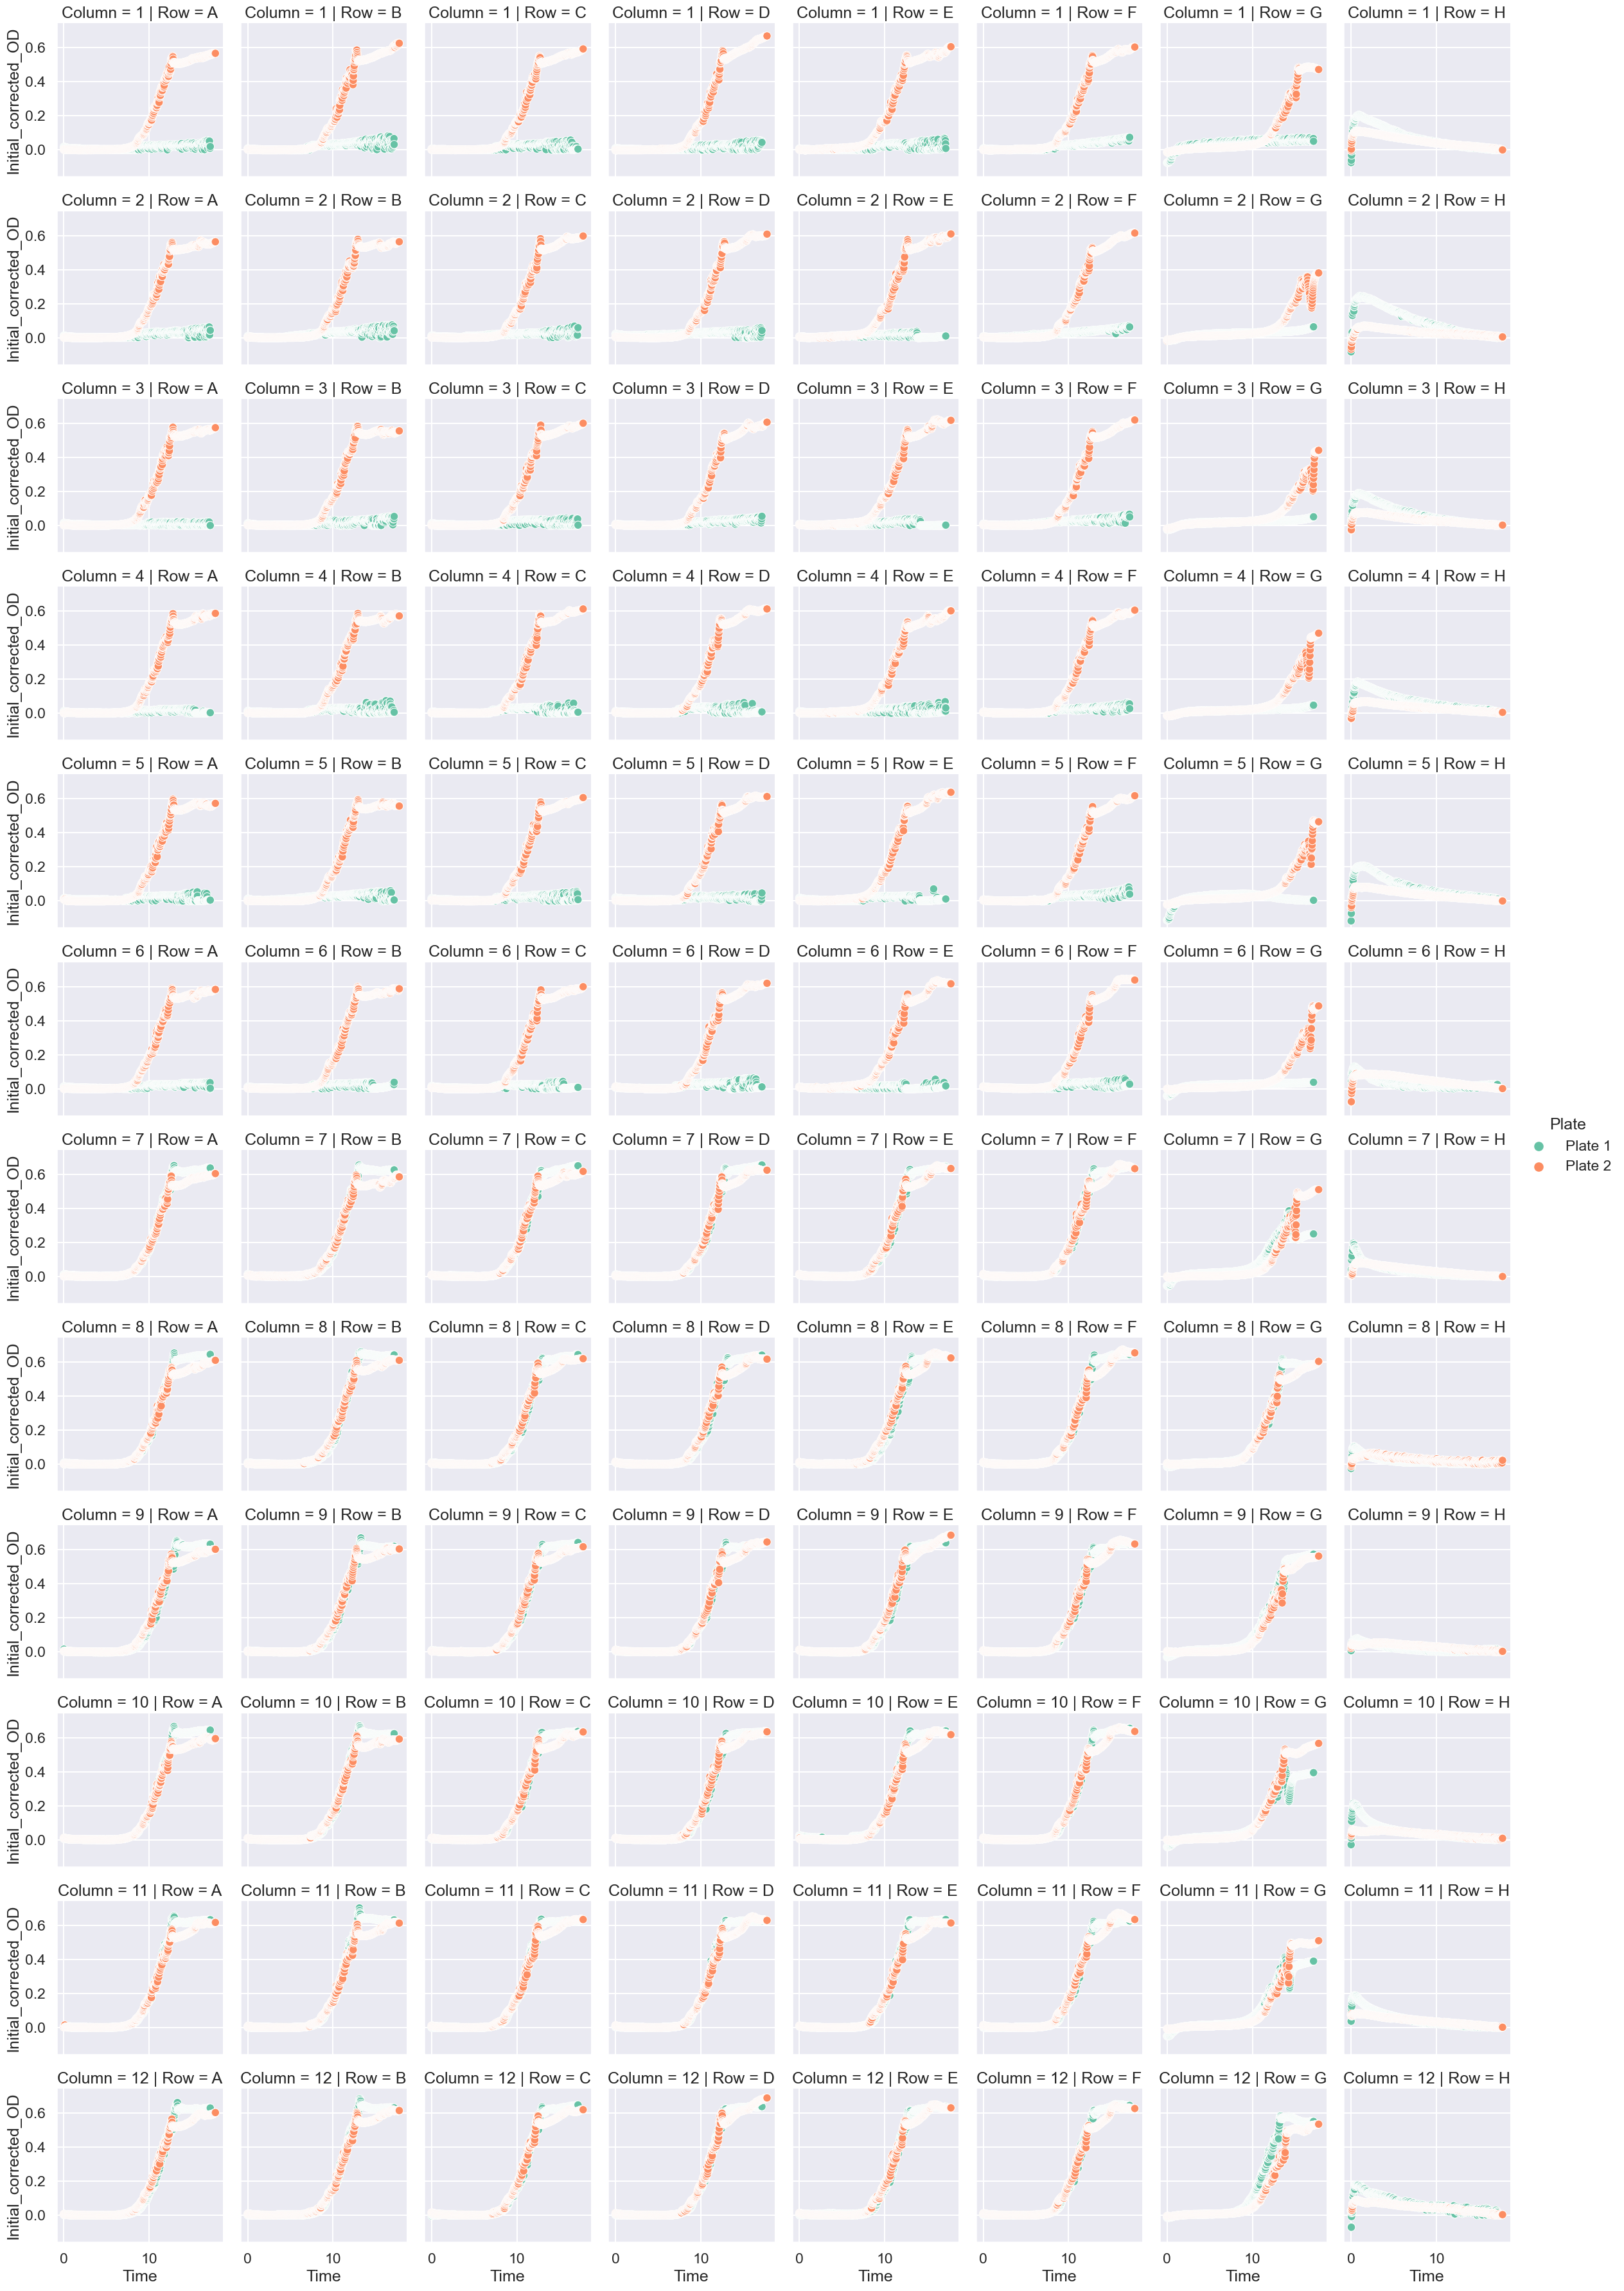

In [47]:
sns.set_context("talk")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", col="Row", row="Column", \
            # row="Genotype", 
            height=3, \
            # col_wrap=4,
            data=mdf)

In [48]:
f_mdf = mdf.filter(pl.col("Time") > 1.5).filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_corrected_OD")).log())
    .alias("Log_initial_corrected_OD")
])

f_mdf = f_mdf.drop_nulls()

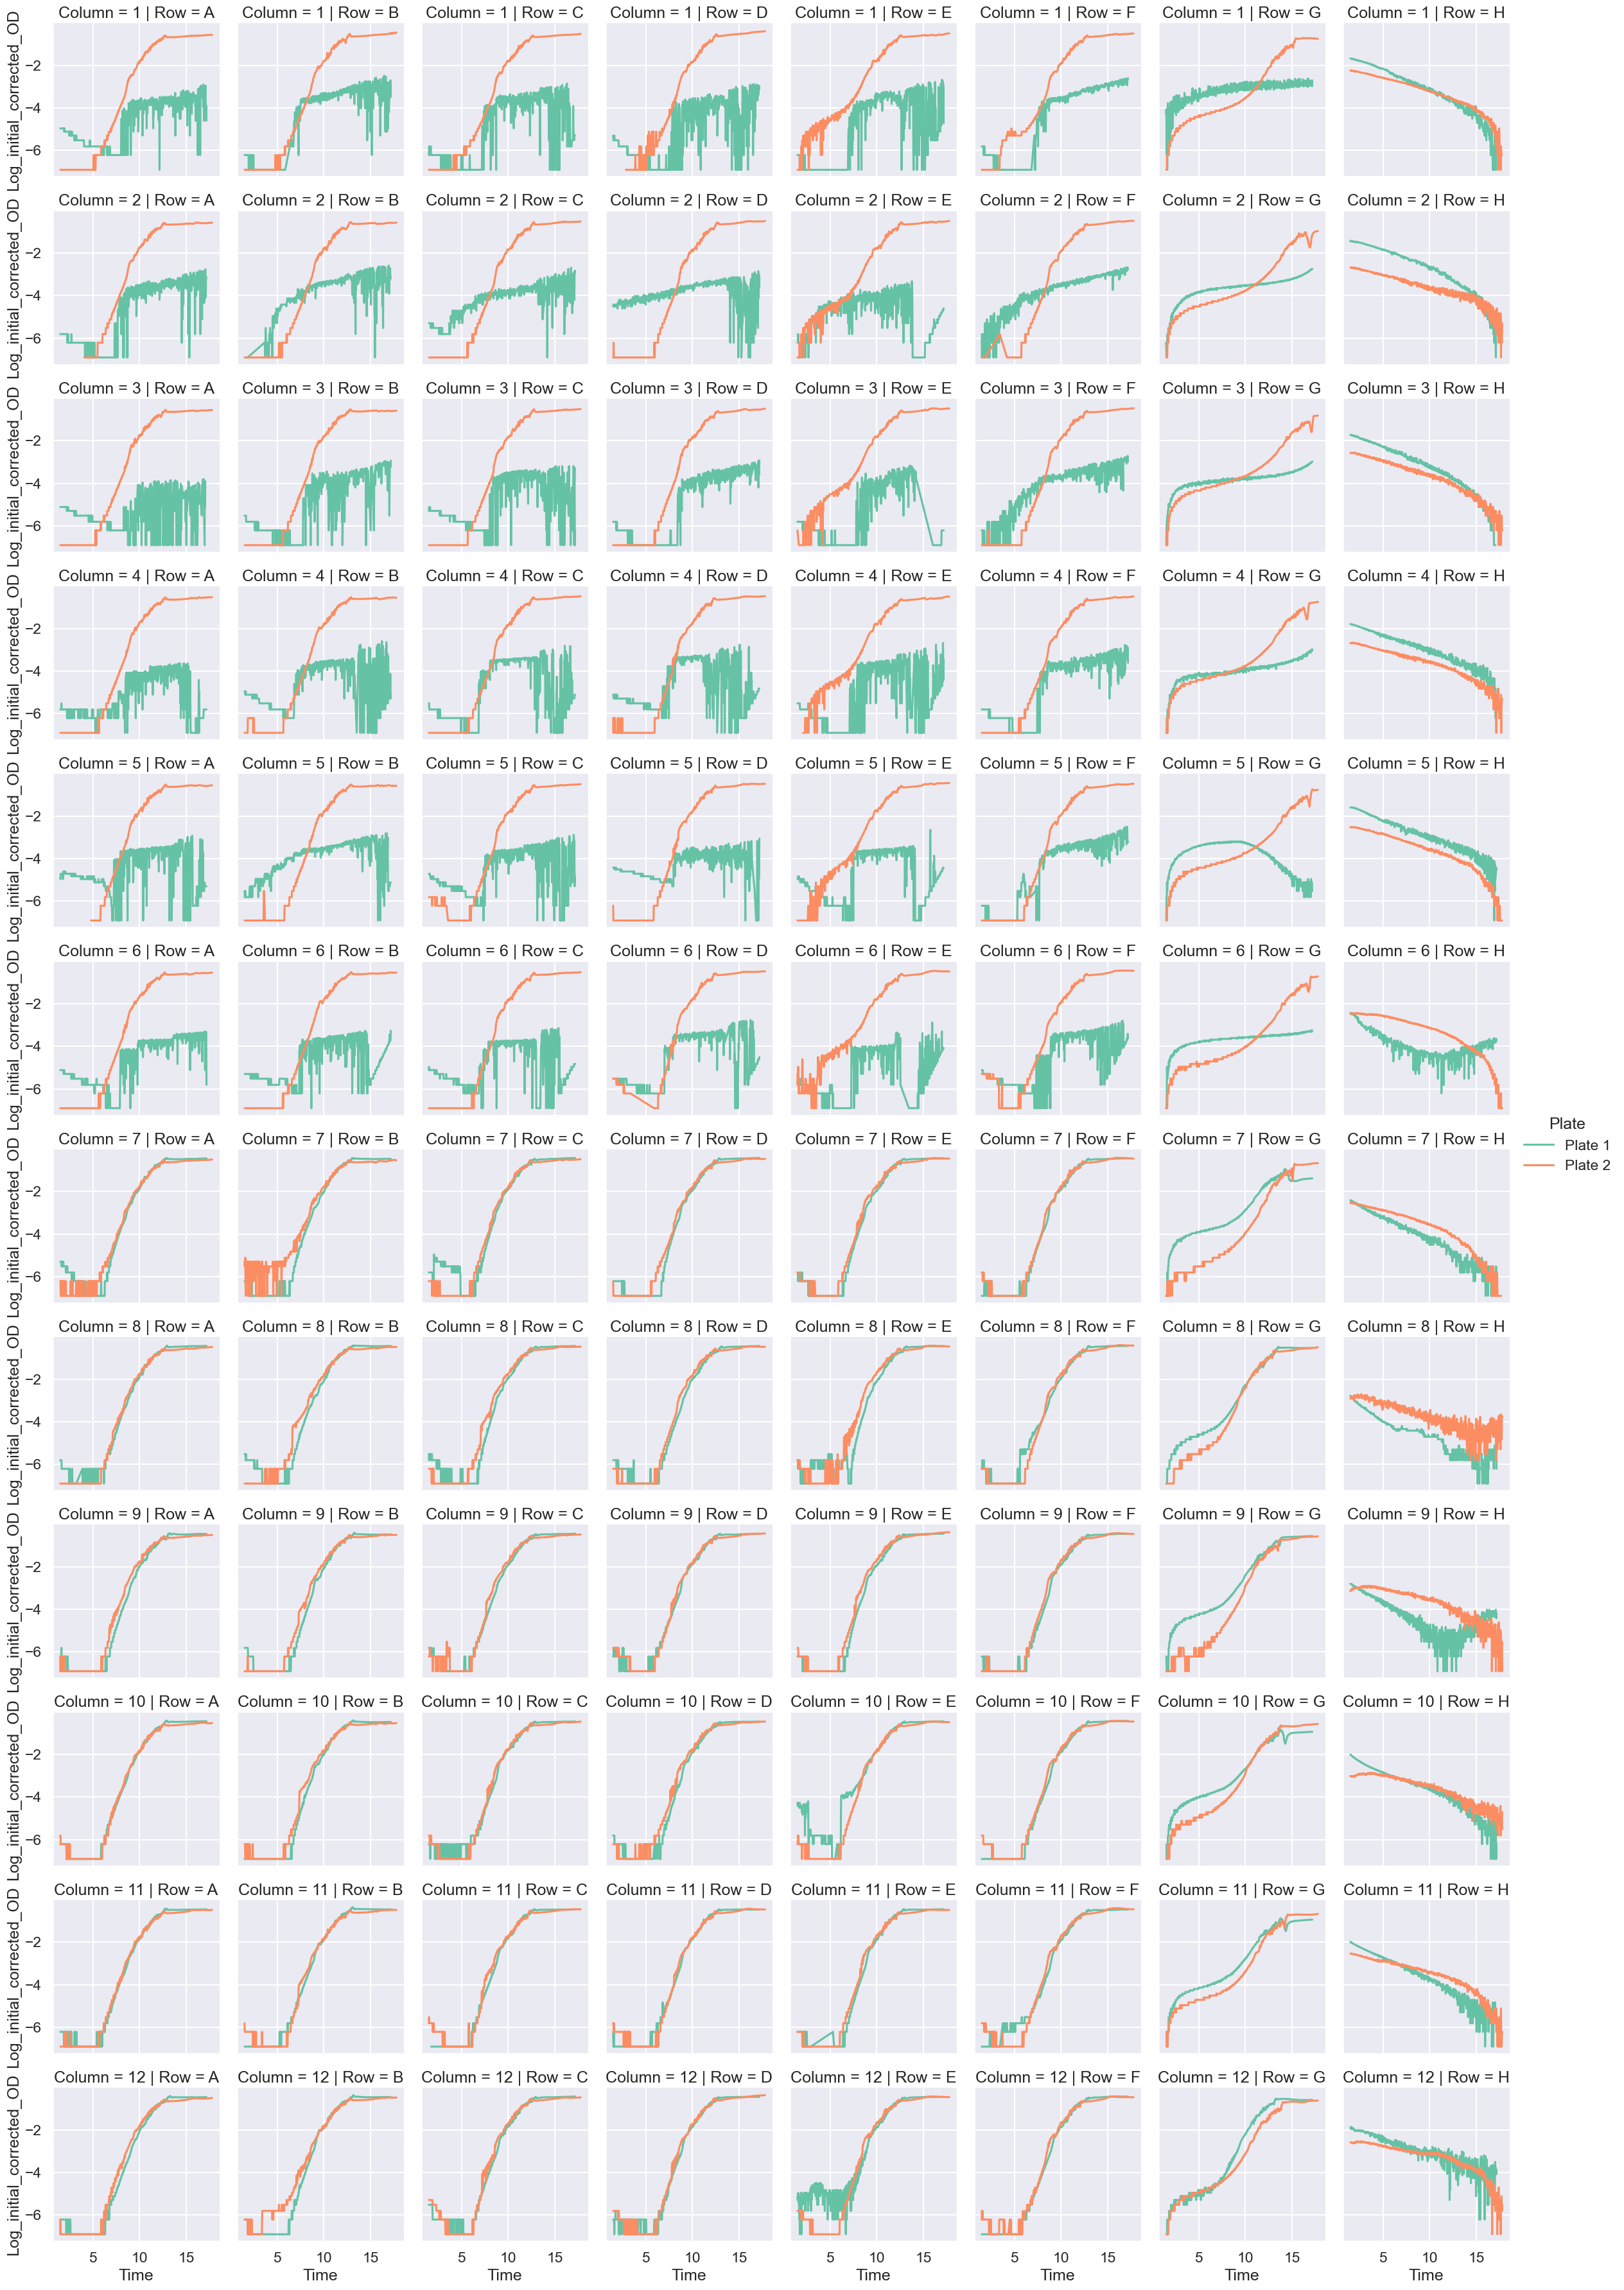

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Column", col="Row", height=3, \
                data=f_mdf.filter(pl.col("Time") < 20))

# plt.savefig("weird_plate.png")

In [58]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -5.5).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -3).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

M = 0
N = 5
top_gr = pl.DataFrame(predicted_gr.sort_values(by=["Genotype", "Additive", "Plate", "slope"], ascending=False).groupby(['Genotype', 'Additive', 'Plate']).nth[M:N])
top_gr.head(7)

gr_df = gr_df.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"])

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_60941/4177081021.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


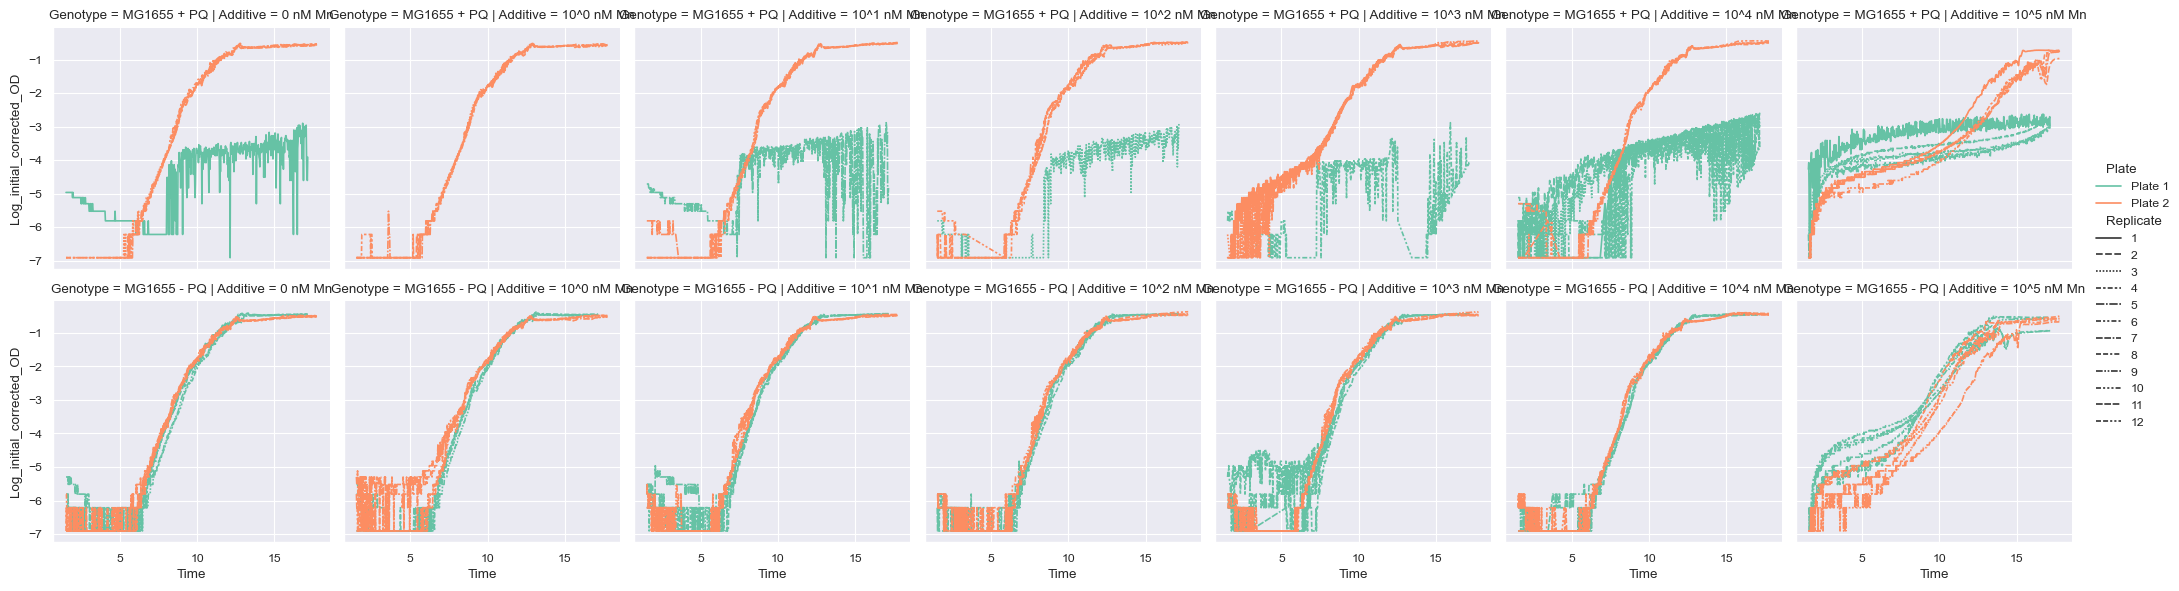

In [59]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Genotype", col="Additive", style="Replicate", height=3, \
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]))

# plt.savefig("weird_plate.png")

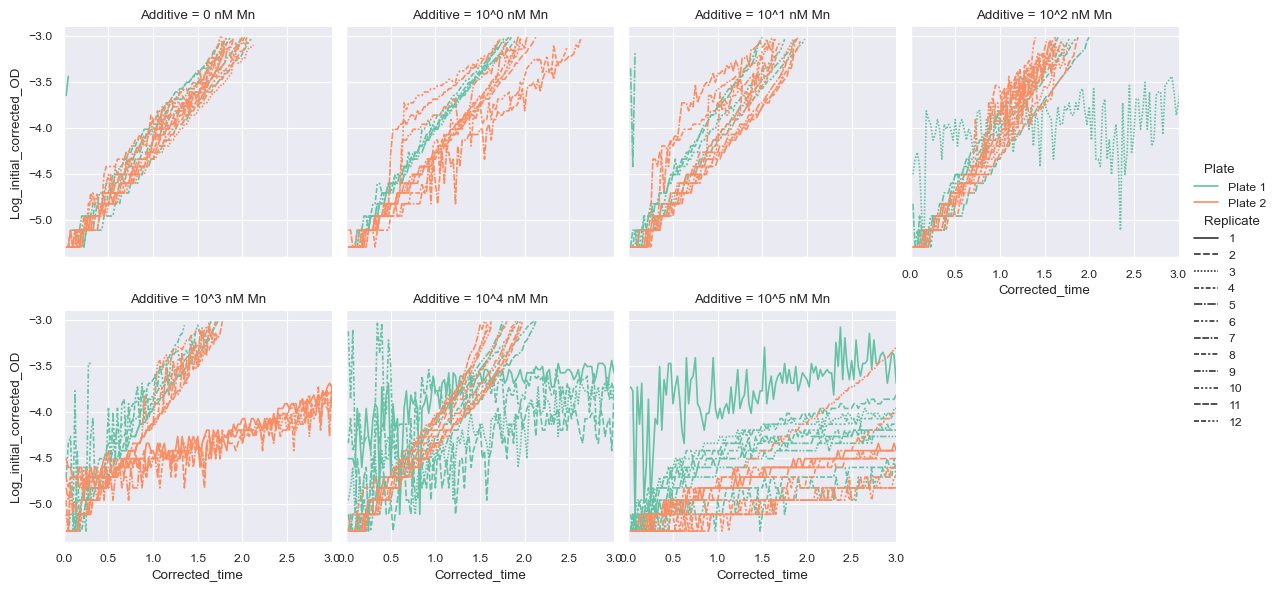

In [60]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                col_wrap=4, 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,3])

# plt.savefig("plates.png")

(0.0, 3.0)

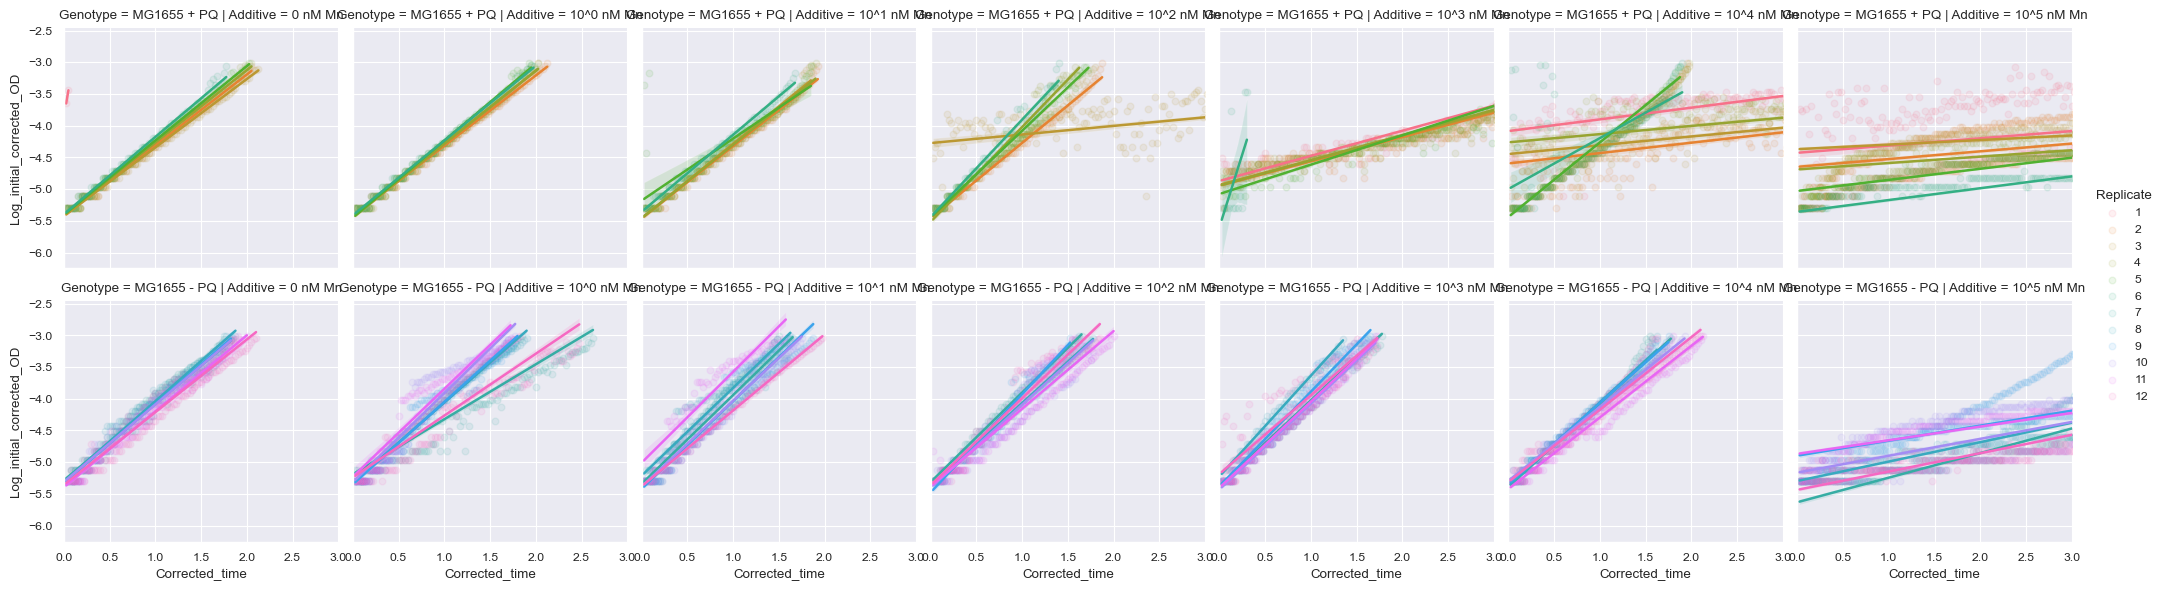

In [61]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", 
           # col_wrap=4,  \
           row="Genotype",
           height=3,
           data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


In [62]:
# sns.relplot(x="Time", y="Log_initial_corrected_OD", kind="line", row="Replicate", col="Additive", height=3, \
#             data=f_mdf.filter(pl.col("Time") < 15))

In [63]:
# sns.set_context("paper")

# sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", style="Replicate", kind="scatter", col="Additive", \
#             # row="Genotype", height=3, \
#             col_wrap=4,
#             data=mdf)

In [64]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]
predicted_gr

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_60941/544480332.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])


Genotype    Additive  Replicate    Plate     slope  intercept  \
0    MG1655 + PQ     0 nM Mn          1  Plate 1  8.305575  -3.857298   
1    MG1655 + PQ     0 nM Mn          2  Plate 2  1.116499  -5.424703   
2    MG1655 + PQ     0 nM Mn          3  Plate 2  1.080573  -5.423843   
3    MG1655 + PQ     0 nM Mn          4  Plate 2  1.142885  -5.408322   
4    MG1655 + PQ     0 nM Mn          5  Plate 2  1.172981  -5.404807   
..           ...         ...        ...      ...       ...        ...   
113  MG1655 - PQ  10^5 nM Mn         10  Plate 1  0.218593  -4.758672   
114  MG1655 - PQ  10^5 nM Mn         10  Plate 2  0.309831  -5.560535   
115  MG1655 - PQ  10^5 nM Mn         11  Plate 1  0.215178  -4.868592   
116  MG1655 - PQ  10^5 nM Mn         12  Plate 1  0.372243  -5.504297   
117  MG1655 - PQ  10^5 nM Mn         12  Plate 2  0.280612  -5.518603   

      slope_e  intercept_e  doubling_time  
0         inf          inf       0.083456  
1    0.006733     0.008042       0.620822  
2    0.007322     0.009062       0.641462  
3    0.007538     0.009003       0.606489  
4    0.006695     0.007899       0.590928  
..        ...          ...            ...  
113  0.002911     0.012382       3.170946  
114  0.004651     0.018510       2.237175  
115  0.003014     0.013213       3.221267  
116  0.010208     0.031641       1.862085  
117  0.004857     0.020382       2.470129  

[118 rows x 9 columns]

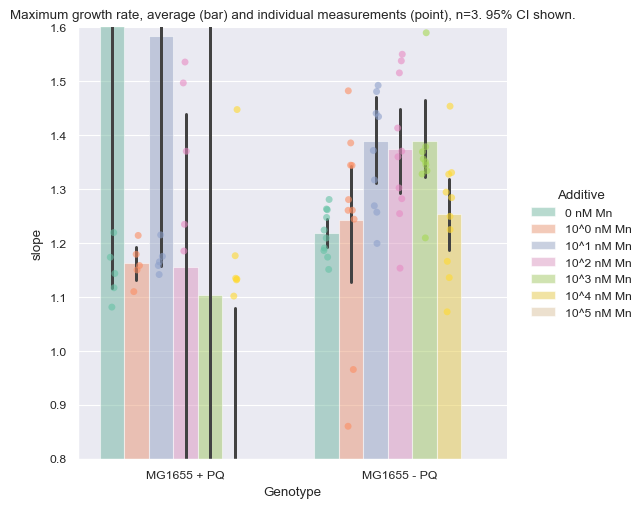

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    filter_df = pl.DataFrame(predicted_gr) # .filter((pl.col("Genotype") == "MG1655 - PQ"))
    filter_df.head(5)
    
    g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
                    data=filter_df.to_pandas(), kind="bar",  
                    height=5, aspect=1, alpha=0.5, errorbar="ci",
                    # col="Plate", col_wrap=3
                       );
    g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
                    hue="Additive", palette="Set2",
                    alpha=0.6, dodge=True)
    
    plt.title("Maximum growth rate, average (bar) and individual measurements (point), n=3. 95% CI shown.")
    plt.ylim([0.8, 1.6])
    
    plt.show()
    
   #  g.savefig("story1.png")

In [25]:
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
    
#     filter_df = pl.DataFrame(predicted_gr).filter((pl.col("Genotype") == "MG1655"))
#     filter_df.head(5)
    
#     g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
#                     data=filter_df.to_pandas(), kind="bar", 
#                     height=5, aspect=1, alpha=0.5, hue_order=["none", "Zn", "B12", "met"], errorbar="ci");
#     g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
#                     hue="Additive", palette="Set2",
#                     alpha=0.6, dodge=True, hue_order=["none", "Zn", "B12", "met"])
    
#     plt.title("Minimum doubling time, average (bar) and individual measurements (point), n=3. 95% CI shown.")
#     plt.ylim([1, 1.3])
    
#     plt.show()
    
#    #  g.savefig("story1.png")

In [26]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Additive", 
           # col_wrap=4,  \
           # hue_order=["none", "Zn", "B12", "met"],
           col="Genotype",
           height=5,
           data=gr_df.filter((pl.col("Genotype") == "MG1655")).to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0, 1.5])


ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x500 with 0 Axes>

In [ ]:
# sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Additive", 
#            # col_wrap=4,  \
#            hue_order=["none", "Zn", "B12", "met"],
#            col="Genotype",
#            height=5,
#            data=gr_df.filter((pl.col("Genotype") == "MG1655")).to_pandas(), scatter_kws = {"alpha": 0.1})

# plt.xlim([0, 1.5])


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                height=3, \
                col_wrap=2, 
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]).filter((pl.col("Genotype") == "MG1655"))   )

# plt.savefig("weird_plate.png")